## Langchain ChatModels

In [14]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core

In [6]:
import os
GEMINI_API_KEY = os.environ['GOOGLE_API_KEY']

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=GEMINI_API_KEY,
    temperature=0.5
)

In [8]:
result = llm.invoke("Hi")
result # Metadata

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8c535f76-d775-479b-ae2d-4b8a5ba2ec12-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [9]:
result.content

'Hi there! How can I help you today?'

In [10]:
from langchain_core.messages import HumanMessage, AIMessage

msg = HumanMessage(content="Hi")

messages = [msg]

result = llm.invoke(messages)
result.content

'Hi there! How can I help you today?'

In [11]:
messages = [
    HumanMessage(content="Hi"),
    AIMessage(content="Hi there! How can I help you today?"),
    HumanMessage(content="What is Langchain?")
]

result = llm.invoke(messages)
result.content

"LangChain is a framework for developing applications powered by large language models (LLMs).  It's designed to make it easier to build these applications by providing a standard structure and reusable components.  Think of it as a toolbox filled with pre-built parts and tools specifically for working with LLMs.\n\nHere's a breakdown of its key features and what makes it useful:\n\n* **Modular Design:** LangChain breaks down the process of building LLM applications into modular components.  This allows developers to easily swap out different LLMs, prompts, memory mechanisms, and other elements without rewriting large portions of their code.\n\n* **Chain Functionality:**  It excels at chaining together different components to create complex workflows. For example, you might chain together a prompt generator, an LLM, and a summarizer to create an application that answers questions from a large document.\n\n* **Memory Management:**  LangChain provides tools for managing the context and m

In [12]:
messages = [
    HumanMessage(content="Hi"),
    AIMessage(content="Hi there! How can I help you today?"),
    HumanMessage(content="What is Langchain?"),
    AIMessage(content="LangChain is a framework for developing applications powered by language models."),
    HumanMessage(content="Where can I learn?")
]

result = llm.invoke(messages)
result.content

'You can learn about LangChain from several sources:\n\n* **Official LangChain Documentation:** This is the best place to start.  The documentation is well-structured and provides comprehensive information on all aspects of the framework, including tutorials and examples.  You can find it at [https://python.langchain.com/en/latest/](https://python.langchain.com/en/latest/).\n\n* **LangChain\'s GitHub Repository:**  The GitHub repository ([https://github.com/langchain-ai/langchain](https://github.com/langchain-ai/langchain)) contains the source code, issue tracker, and contributions from the community.  It\'s a valuable resource for understanding the inner workings of LangChain and contributing to its development.\n\n* **Tutorials and Blog Posts:** Many tutorials and blog posts are available online that cover various aspects of LangChain.  Searching for "LangChain tutorial" or "LangChain examples" on Google or YouTube will yield numerous results.  Look for tutorials that focus on specif

In [13]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## State

In [15]:
from typing_extensions import TypedDict

class LearningState(TypedDict):
    prompt: str

In [16]:
mac_state : LearningState = LearningState(prompt="Hello from Macbook Air M1")

In [ ]:
print(mac_state)
print(mac_state["prompt"])
print(mac_state["prompt"] + ". I am built by Apple Inc.")
print(type(mac_state))

{'prompt': 'Hello from Macbook Air M1'}
Hello from Macbook Air M1
Hello from Macbook Air M1. I am built by Apple Inc.
<class 'dict'>


## Nodes

In [25]:
def node_1(state: LearningState) -> LearningState:
    print("---Node 1 State---", state)
    return {"prompt": state['prompt'] + " I am "}

def node_2(state: LearningState) -> LearningState:
    print("---Node 2 State---", state)
    return {'prompt': state['prompt'] + "a Macbook Air M1"}

## Edges and Graph Connections

In [26]:
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

builder: StateGraph = StateGraph(state_schema=LearningState)

In [27]:
print(type(builder))

<class 'langgraph.graph.state.StateGraph'>


In [28]:
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

In [29]:
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

In [30]:
graph: CompiledStateGraph = builder.compile()

In [33]:
print(graph)
print(type(graph))
print(graph.get_graph())

<class 'langgraph.graph.state.CompiledStateGraph'>
Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'node_1': Node(id='node_1', name='node_1', data=node_1(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'node_2': Node(id='node_2', name='node_2', data=node_2(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langchain_core.utils.pydantic.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='node_1', data=None, conditional=False), Edge(source='node_1', target='node_2', data=None, conditional=False), Edge(source='node_2', target='__end__', data=None, conditional=False)])


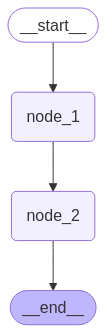

In [34]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Invoke

In [35]:
graph.invoke({"prompt": "Hey"})

---Node 1 State--- {'prompt': 'Hey'}
---Node 2 State--- {'prompt': 'Hey I am '}


{'prompt': 'Hey I am a Macbook Air M1'}

## Using LLM in Nodes

In [36]:
from typing_extensions import TypedDict

class LLMAgentCall(TypedDict):
    prompt: str
    output: str

In [37]:
def node_1(state: LLMAgentCall):
    print("---Node 1 State---", state)
    prompt = state['prompt']
    ai_msg: AIMessage = llm.invoke(prompt)
    return {"prompt": prompt, "output": ai_msg.content}

In [38]:
greet_message = node_1(LLMAgentCall(prompt="Hi"))
greet_message

---Node 1 State--- {'prompt': 'Hi'}


{'prompt': 'Hi', 'output': 'Hi there! How can I help you today?'}

In [47]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Build Graph
builder: StateGraph = StateGraph(state_schema=LLMAgentCall)

# Create Nodes
builder.add_node("node_1", node_1)

# Create Edges
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Compile Graph
graph: CompiledStateGraph = builder.compile()

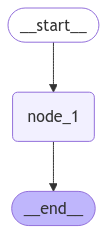

In [40]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
graph.invoke({"prompt": "Hi"})

---Node 1 State--- {'prompt': 'Hi'}


{'prompt': 'Hi', 'output': 'Hi there! How can I help you today?'}